In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


🔄  Carregando modelo...
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
✅  Sinal simulado salvo: (900000, 2)


<ipython-input-10-3731833893>:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.legend(markerscale=6); plt.tight_layout()
<ipython-input-10-3731833893>:84: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(png_path, dpi=300); plt.show()


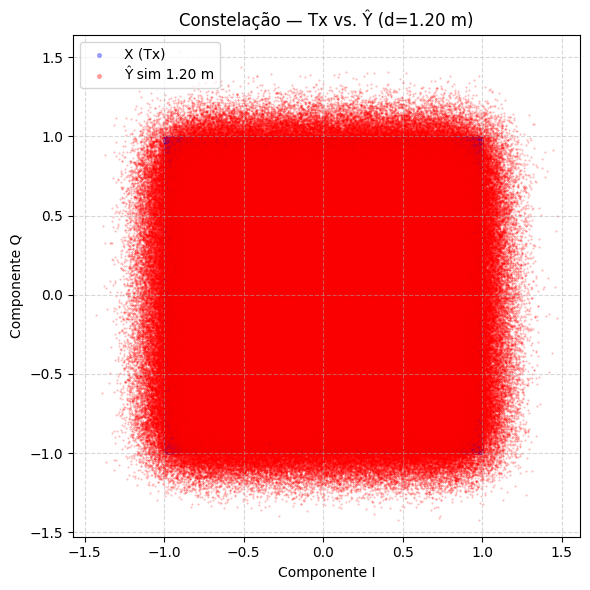

📈 Plot salvo em: /content/drive/MyDrive/Temp/simulacao_1p2m/constelacao_1.20m.png


In [ ]:
# ===============================================================
#  SIMULAÇÃO + PLOT + SALVAMENTO  (TUDO-EM-UMA CÉLULA)
# ===============================================================
# CONFIGURAÇÃO  ──────────────────────────────────────────────────
MODEL_PATH  = "/content/drive/MyDrive/Temp/IQ_data/logs_runs/cvae_campeao.keras"
X_FILE      = "/content/drive/MyDrive/Temp/FULLSQUARE/sent_data_tuple.npy"
DIST_M      = 1.2                      # distância desejada (m)
OUT_DIR     = "/content/drive/MyDrive/Temp/simulacao_1p2m"
BATCH_SZ    = 16384                    # ↓ se faltar memória
DECODER_OUT = os.path.join(OUT_DIR, "cvae_decoder.keras")  # onde salvar o decoder
# ───────────────────────────────────────────────────────────────

import os, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras import layers, models
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Classes custom (ident. às do treino) ---------------
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mu, z_logv = inputs
        eps = tf.random.normal(tf.shape(z_mu))
        return z_mu + tf.exp(0.5 * z_logv) * eps

class VAELossLayer(layers.Layer):
    def __init__(self, beta=1.0, name="vae_loss_layer", **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = tf.Variable(beta, trainable=False, dtype=tf.float32)
    def call(self, inputs):             # perda não usada na inferência
        return inputs[1][:, :2]

# ---------- 1) Carrega CVAE completo ---------------------------
print("🔄  Carregando modelo...")
cvae = models.load_model(
        MODEL_PATH,
        custom_objects={"VAELossLayer": VAELossLayer, "Sampling": Sampling},
        compile=False)

# ---------- 2) Extrai e salva o DECODER ------------------------
decoder = cvae.get_layer("conditional_decoder")
decoder.save(DECODER_OUT, include_optimizer=False)
latent_dim = decoder.input[0].shape[-1]
print("💾 Decoder salvo em:", DECODER_OUT)

# ---------- 3) Prepara X e vetor de distância ------------------
X = np.load(X_FILE)
if X.ndim == 1 and X.size == 2:               # (2,) -> (1,2)
    X = X.reshape(1, 2)
elif X.ndim == 2 and X.shape[1] != 2 and X.shape[0] == 2:
    X = X.T                                   # (2,N) -> (N,2)
assert X.ndim == 2 and X.shape[1] == 2, f"Shape inesperado: {X.shape}"

d_norm = (DIST_M - 0.5) / 1.0                 # mesma normalização
D = np.full((len(X), 1), d_norm, dtype=np.float32)
cond_vec = np.concatenate([X, D], axis=1)

# ---------- 4) Gera amostras de z e prediz ---------------------
np.random.seed(33)
z_samples = np.random.normal(size=(len(X), latent_dim)).astype(np.float32)

dec_out = decoder.predict([z_samples, cond_vec], batch_size=BATCH_SZ, verbose=1)
Y_hat   = dec_out[:, :2]                      # usamos a média μ

# ---------- 5) Salva .npy --------------------------------------
npy_path = os.path.join(OUT_DIR, f"y_hat_{DIST_M:.2f}m.npy")
np.save(npy_path, Y_hat)
print(f"✅ Sinal simulado salvo: {npy_path} (shape={Y_hat.shape})")

# ---------- 6) Plot da constelação -----------------------------
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1],     s=0.2, alpha=0.3, label="X (Tx)", color="blue")
plt.scatter(Y_hat[:,0], Y_hat[:,1], s=0.2, alpha=0.3,
            label=f"Ŷ sim {DIST_M:.2f} m", color="red")
plt.title(f"Constelação — Tx vs. Ŷ (d={DIST_M:.2f} m)")
plt.xlabel("Componente I"); plt.ylabel("Componente Q")
plt.axis("equal"); plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(markerscale=6); plt.tight_layout()

png_path = os.path.join(OUT_DIR, f"constelacao_{DIST_M:.2f}m.png")
plt.savefig(png_path, dpi=300); plt.show()
print("📈 Plot salvo em:", png_path)
